# LeNet and LeNet-5: Pioneering CNN Architectures

LeNet {footcite}`lecun1989backpropagation` was one of the pioneering CNNs that revolutionized computer vision. At a time when machine learning relied heavily on hand-engineered features, LeNet demonstrated that neural networks could automatically learn to recognize visual patterns. Its most successful implementation, LeNet-5 (1998), achieved impressive accuracy in reading handwritten digits, finding practical application in processing postal codes and bank checks across the United States.


## Architecture

There are multiple versions of LeNet. We will focus on the seminal version of LeNet {footcite}`lecun1989backpropagation` and the most successful version of LeNet, LeNet-5 {footcite}`lecun1998gradient`.

## LeNet-1

LeNet-1 is the first version of LeNet. It represents a proof-of-concept of the idea that CNNs can be used for handwritten digit recognition.

```{figure} https://miro.medium.com/v2/resize:fit:1400/format:webp/1*ge5OLutAT9_3fxt_sKTBGA.png
---
width: 50%
name: lenet
---
LeNet-1 architecture.
```

- The network begins with a convolutional layer that applies 4 feature maps using 5×5 kernels.

- Following C1, an average pooling layer (S2) performs subsampling using 2×2 windows, reducing the spatial dimensions.

- The network then applies a second convolution-pooling pair (C3 and S4), this time using 12 feature maps of size 8x8 and 4x4, respectively.

- Finally, the network flattens the processed features and passes them through fully connected layers, combining all the extracted features to make the final digit prediction.

LeNet mirrors how human vision works, i.e., it processes images in layers, starting with basic features and building up to complex patterns. This approach laid the groundwork for modern computer vision systems.

### LeNet-5

```{figure} https://www.datasciencecentral.com/wp-content/uploads/2021/10/1lvvWF48t7cyRWqct13eU0w.jpeg
---
width: 100%
name: lenet-5
---
LeNet-5 architecture.
```

LeNet-5 is essentially a larger version of LeNet-1 with more parameters and some architectural improvements.

1. **Input normalization**: The input is a 32×32 grayscale image. While LeNet-1 takes the raw pixel values, LeNet-5 normalizes the pixel values to fall within [-0.1, 1.175], where the white (background) corresponds to a value of -0.1 and the black (foreground) corresponds to a value of 1.175. This makes the mean input roughly 0 and the variance roughly 1, which accelerates learning.

2. **Convolutional + Subsampling + Activation**: LeNet-5 uses two pairs of convolutional and pooling (subsampling) layers. In LeNet-5, the pooling layer is a mean pooling layer that computes the mean value of each 2x2 patch. The subsampled feature maps are then passed through a sigmoid activation function to introduce non-linearity.

4. **Sparse connectivity**: In LeNet-5, there is a special convolutional layer (C3) that generates 16 feature maps, each of which is based on a combination of different S2 feature maps. The combination is determined by the connection table as shown below.
    ```{figure} https://miro.medium.com/v2/resize:fit:894/1*eAwGLH0U4ndCyqInDBhiyg.png
    ---
    width: 50%
    name: lenet-5-sparse-connectivity
    align: center
    ---
    Sparse connectivity in LeNet-5.
    ```
    The main reason for this sparse connectivity is to diversify the feature maps generated by C3. Namely, if we generate all feature maps from all S2 feature maps, the output feature maps will be highly correlated since they are generated from the same set of S2 feature maps. By constraining the connectivity, C3 forces the network to learn more diverse features. Another added value is the parameter reduction.

5. **From 2D feature maps to 1D feature vector**: Convolution and pooling layers generate 2D feature maps. The last step is to transform it into a 1D feature vector. A naive approch is to flatten the feature maps. However, this is not efficient since it discards the spatial information. Instead, LeNet-5 uses a convolutional layer (C5) followed by a fully connected layer and Radial Basis Function (RBF) layer to transform the 2D feature maps into a 1D feature vector. Interested readers can refer to the original paper for more details {footcite}`lecun1998gradient`.


## Hands-on

Let us implement LeNet-1 using PyTorch. We note that this is not a faithful implementation of LeNet-1. We will use some modern techniques such as the Adam optimizer to speed up the training process.

We will use the MNIST dataset for this example. This dataset is a collection of handwritten digits, with goal of classifying the digit into one of the 10 classes.

```{figure} https://production-media.paperswithcode.com/datasets/MNIST-0000000001-2e09631a_09liOmx.jpg
---
width: 100%
name: mnist
---
MNIST dataset.
```

### Prepare the dataset

To start, let us first prepare the dataset. We will use pytorch-lightning to create a dataloader for the MNIST dataset.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from torchmetrics import Accuracy

class MNISTDataModule(pl.LightningDataModule):
    """
    PyTorch Lightning data module for MNIST dataset
    """
    def __init__(self, data_dir: str = './data', batch_size: int = 32):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size

        # Define transforms
        self.transform = transforms.Compose([
            transforms.ToTensor(), # convert to tensor
            transforms.Normalize((0,), (1,)) # normalize the data such that the mean is 0 and the standard deviation is 1
        ])

    def prepare_data(self):
        """Download data if needed"""
        datasets.MNIST(self.data_dir, train=True, download=True)
        datasets.MNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        """Setup train, val, and test datasets"""
        if stage == 'fit' or stage is None:
            mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
            self.mnist_train, self.mnist_val = random_split(
                mnist_full, [55000, 5000], generator=torch.Generator().manual_seed(42)
            )

        if stage == 'test' or stage is None:
            self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=1)

    def val_dataloader(self):
        return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=1)

    def test_dataloader(self):
        return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=1)

#### About PyTorch Lightning DataModule

Let us break down the MNIST DataModule code. The MNISTDataModule class is a PyTorch Lightning implementation for handling the MNIST dataset. It inherits from `pl.LightningDataModule`, which provides a structured way to organize dataset-related code.

The initialization of the DataModule sets up basic configurations and transforms:

```python
def __init__(self, data_dir: str = './data', batch_size: int = 32):
    super().__init__()
    self.data_dir = data_dir
    self.batch_size = batch_size
    self.transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0,), (1,))
    ])
```

The transformation pipeline consists of two steps. First, `transforms.ToTensor()` converts the PIL images to PyTorch tensors and scales the pixel values from [0, 255] to [0, 1]. Then, `transforms.Normalize((0,), (1,))` standardizes the data to have a mean of 0 and standard deviation of 1. This normalization is crucial for stable training and faster convergence of neural networks.

The `prepare_data()` method handles dataset downloading:

```python
def prepare_data(self):
    datasets.MNIST(self.data_dir, train=True, download=True)
    datasets.MNIST(self.data_dir, train=False, download=True)
```

This method ensures the MNIST dataset is downloaded if it's not already present. It's called automatically by PyTorch Lightning and runs only on the first GPU in distributed settings.

The `setup()` method prepares the train, validation, and test splits:

```python
def setup(self, stage=None):
    if stage == 'fit' or stage is None:
        mnist_full = datasets.MNIST(self.data_dir, train=True, transform=self.transform)
        self.mnist_train, self.mnist_val = random_split(
            mnist_full, [55000, 5000], generator=torch.Generator().manual_seed(42)
        )
    if stage == 'test' or stage is None:
        self.mnist_test = datasets.MNIST(self.data_dir, train=False, transform=self.transform)
```

This method splits the training data into training and validation sets (55,000 and 5,000 samples respectively). The `random_split` uses a fixed seed (42) for reproducibility. The test set remains separate and uses the official MNIST test split.

Finally, the DataModule provides three dataloader methods:

```python
def train_dataloader(self):
    return DataLoader(self.mnist_train, batch_size=self.batch_size, shuffle=True, num_workers=1)

def val_dataloader(self):
    return DataLoader(self.mnist_val, batch_size=self.batch_size, num_workers=1)

def test_dataloader(self):
    return DataLoader(self.mnist_test, batch_size=self.batch_size, num_workers=1)
```

These methods create DataLoader instances for each dataset split. The training dataloader shuffles the data to prevent the model from learning the order of samples. All loaders use a single worker (`num_workers=1`) for data loading, though this can be increased for better performance on more powerful systems.

For more detailed information about PyTorch Lightning DataModules and the MNIST dataset, you can refer to:
- [PyTorch Lightning DataModule Documentation](https://lightning.ai/docs/pytorch/stable/data/datamodule.html)
- [torchvision.datasets.MNIST Documentation](https://pytorch.org/vision/stable/datasets.html#mnist)
- [PyTorch DataLoader Documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)


### Define the model

In [2]:
class LeNet1(pl.LightningModule):
    """
    PyTorch Lightning implementation of LeNet-1
    Includes training, validation, and test functionality
    """

    def __init__(self, learning_rate=1e-3):
        super(LeNet1, self).__init__()
        self.save_hyperparameters()

        # Metrics
        self.train_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=10)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=10)

        # First convolutional layer (1x28x28 -> 4x24x24)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=5, stride=1)

        # Average pooling layer (4x24x24 -> 4x12x12)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        # Second convolutional layer (4x12x12 -> 12x8x8)
        self.conv2 = nn.Conv2d(in_channels=4, out_channels=12, kernel_size=5, stride=1)

        # Fully connected layer (12*4*4=192 -> 10)
        self.fc = nn.Linear(12 * 4 * 4, 10)

        # Initialize weights
        self._init_weights()

        # Initialize validation losses
        self.val_losses = []
        self.train_losses = []

    def _init_weights(self):
        """Initialize weights using Xavier initialization"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        # First conv block
        x = self.conv1(x)
        x = torch.tanh(
            x
        )  # while the original paper does not mention the activation function, we use tanh here
        x = self.pool(x)

        # Second conv block
        x = self.conv2(x)
        x = torch.tanh(
            x
        )  # while the original paper does not mention the activation function, we use tanh here
        x = self.pool(x)

        # Flatten and fully connected
        x = x.view(-1, 12 * 4 * 4)
        x = self.fc(x)
        return x

    def configure_optimizers(self):
        """Define optimizers and LR schedulers"""
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, mode="min", factor=0.1, patience=10, verbose=True
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {"scheduler": scheduler, "monitor": "val_loss"},
        }

    def training_step(self, batch, batch_idx):
        """Training step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Log metrics
        acc = self.train_accuracy(logits, y)
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)

        self.train_losses.append({"loss": loss.item(), "acc": acc.item()})

        return loss

    def validation_step(self, batch, batch_idx):
        """Validation step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Log metrics
        acc = self.val_accuracy(logits, y)
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        self.val_losses.append({"loss": loss.item(), "acc": acc.item()})

    def test_step(self, batch, batch_idx):
        """Test step"""
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)

        # Log metrics
        acc = self.test_accuracy(logits, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

### Train the model

In [3]:
    # Initialize model and data
    model = LeNet1(learning_rate=1e-3)
    data_module = MNISTDataModule(batch_size=256)

    # Initialize trainer
    trainer = pl.Trainer(
        max_epochs=2,
        accelerator="auto",  # Uses GPU if available
        devices=1,
    )

    # Train and test
    trainer.fit(model, data_module)

GPU available: True (mps), used: True


TPU available: False, using: 0 TPU cores


HPU available: False, using: 0 HPUs


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0      | train
1 | val_accuracy   | MulticlassAccuracy | 0      | train
2 | test_accuracy  | MulticlassAccuracy | 0      | train
3 | conv1          | Conv2d             | 104    | train
4 | pool           | AvgPool2d          | 0      | train
5 | conv2          | Conv2d             | 1.2 K  | train
6 | fc             | Linear             | 1.9 K  | train
--------------------------------------------------------------
3.2 K     Trainable params
0         Non-trainable params
3.2 K     Total params
0.013     Total estimated model params size

Sanity Checking: |                                                                        | 0/? [00:00<?, ?it/…

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'val_dataloader' to speed up the dataloader worker initialization.


/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Training: |                                                                               | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

Validation: |                                                                             | 0/? [00:00<?, ?it/…

`Trainer.fit` stopped: `max_epochs=2` reached.


Let us check if the validation loss is decreasing.

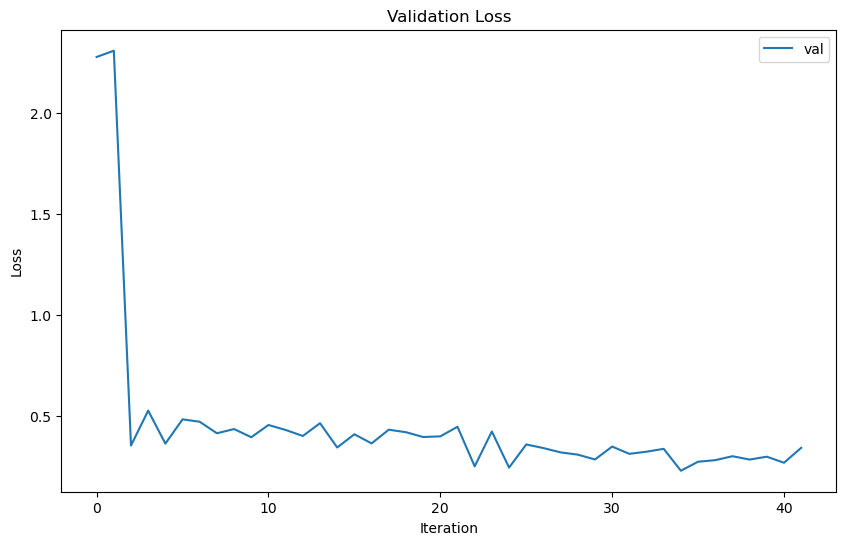

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df_val = pd.DataFrame(model.val_losses)
df_val["Iteration"] = df_val.index

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.lineplot(x="Iteration", y="loss", data=df_val, label="val")
ax.set_title("Validation Loss")
ax.set_xlabel("Iteration")
ax.set_ylabel("Loss")
plt.show()

Let us test the model on the test dataset.

In [5]:
    trainer.test(model, data_module)

/Users/skojaku-admin/miniforge3/envs/advnetsci/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:420: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing: |                                                                                | 0/? [00:00<?, ?it/…

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.9226999878883362     │
│         test_loss         │    0.27479100227355957    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.27479100227355957, 'test_acc': 0.9226999878883362}]

We see that LeNet-1 achieves a very high accuracy on the test dataset, despite the fact that it is a very simple model.


## 🔥Exercise🔥

- Try training the model by yourself using [Notebook](https://github.com/skojaku/applied-soft-comp/blob/master/notebooks/lenet.ipynb)
- Hand draw a digit and see if the model can predict it correctly.
- If it does not work, think about why it does not work and how you can improve the model.

```{footbibliography}
:style: unsrt
:filter: docname in docnames
```